Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [3]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train=pathlib.Path('/content/gdrive/MyDrive/SkinCancerDataset/Train')
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/SkinCancerDataset/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, batch_size=batch_size, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2,subset='training'
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test, batch_size=batch_size, image_size=(img_height,
    img_width), shuffle=True, seed=123, validation_split=0.2,subset='validation'
)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob


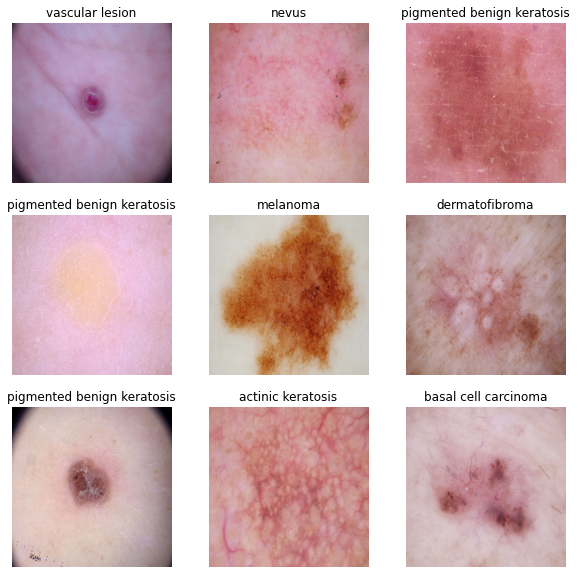

In [12]:

plt.figure(figsize=(10, 10))
for img, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [15]:
num_classes = len(class_names)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [16]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [18]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 236s 182ms/step - loss: 1.9998 - accuracy: 0.2667 - val_loss: 2.2980 - val_accuracy: 0.2609
Epoch 2/20
56/56 [==============================] - 1s 21ms/step - loss: 1.6257 - accuracy: 0.4169 - val_loss: 2.4430 - val_accuracy: 0.2174
Epoch 3/20
56/56 [==============================] - 1s 21ms/step - loss: 1.4238 - accuracy: 0.5084 - val_loss: 2.4053 - val_accuracy: 0.2609
Epoch 4/20
56/56 [==============================] - 1s 21ms/step - loss: 1.3867 - accuracy: 0.5257 - val_loss: 2.2490 - val_accuracy: 0.3043
Epoch 5/20
56/56 [==============================] - 1s 21ms/step - loss: 1.2781 - accuracy: 0.5430 - val_loss: 1.9872 - val_accuracy: 0.2609
Epoch 6/20
56/56 [==============================] - 1s 21ms/step - loss: 1.2102 - accuracy: 0.5647 - val_loss: 3.1107 - val_accuracy: 0.2609
Epoch 7/20
56/56 [==============================] - 1s 21ms/step - loss: 1.1443 - accuracy: 0.5949 - val_loss: 4.2582 - val_accuracy: 0.1304
Epoch 8/20
56/56 [===

### Visualizing training results

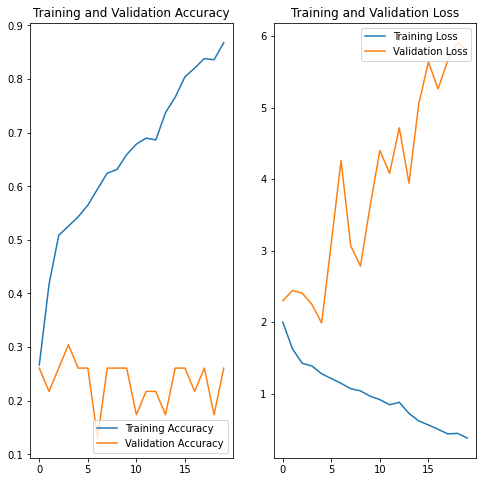

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### From the plot we can understand that the difference between the training accuracy and validation accuracy is large and the model has achieved around 25-30%  accuracy on the validation set.
### It is a sign of Overfitting

In [20]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

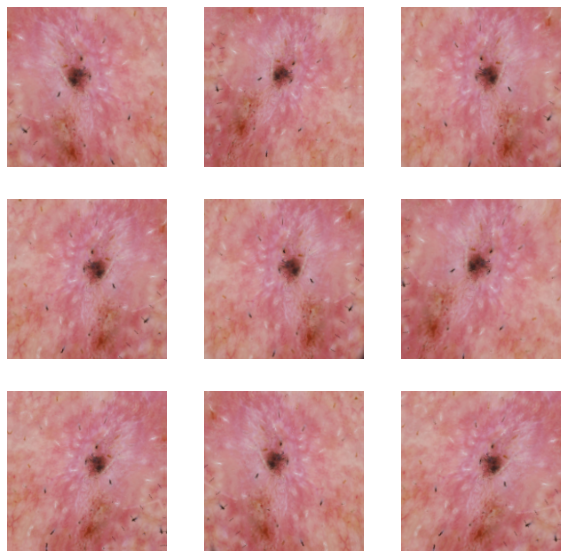

In [21]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [22]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax', name="outputs")
])



### Compiling the model

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [24]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 2s 27ms/step - loss: 1.9554 - accuracy: 0.2874 - val_loss: 2.4609 - val_accuracy: 0.1739
Epoch 2/20
56/56 [==============================] - 1s 23ms/step - loss: 1.6110 - accuracy: 0.4330 - val_loss: 2.6614 - val_accuracy: 0.3043
Epoch 3/20
56/56 [==============================] - 1s 24ms/step - loss: 1.4700 - accuracy: 0.4794 - val_loss: 2.9637 - val_accuracy: 0.1739
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3882 - accuracy: 0.5100 - val_loss: 2.8218 - val_accuracy: 0.2609
Epoch 5/20
56/56 [==============================] - 1s 23ms/step - loss: 1.3419 - accuracy: 0.5363 - val_loss: 2.7191 - val_accuracy: 0.3043
Epoch 6/20
56/56 [==============================] - 1s 24ms/step - loss: 1.2889 - accuracy: 0.5385 - val_loss: 3.3441 - val_accuracy: 0.1739
Epoch 7/20
56/56 [==============================] - 1s 24ms/step - loss: 1.2521 - accuracy: 0.5580 - val_loss: 3.1085 - val_accuracy: 0.1739
Epoch 8/20
56

### Visualizing the results

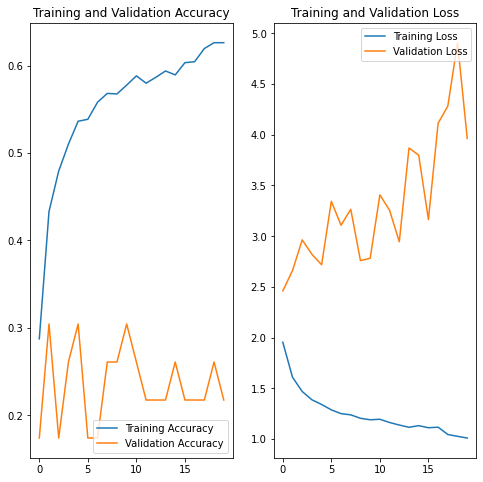

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

### From the plots , we can understand that there is not much impact on the Model overfitting . The model is still Overfitting . But there is very minimal improvemement from the previous model as the difference between the test accuracy and validation accuracy has reduced 

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [26]:
dfx= pd.DataFrame()
for i in range (9):
  
  file_path= '/content/gdrive/MyDrive/SkinCancerDataset/Train/'+class_names[i]
  
  image_path=len(glob.glob(file_path +'/*.jpg'))
  dfx=dfx.append({'ClassName': class_names[i], 'No Of Images':image_path},ignore_index=True)

print(dfx)

                    ClassName  No Of Images
0           actinic keratosis         114.0
1        basal cell carcinoma         376.0
2              dermatofibroma          95.0
3                    melanoma         438.0
4                       nevus         357.0
5  pigmented benign keratosis         462.0
6        seborrheic keratosis          77.0
7     squamous cell carcinoma         181.0
8             vascular lesion         139.0


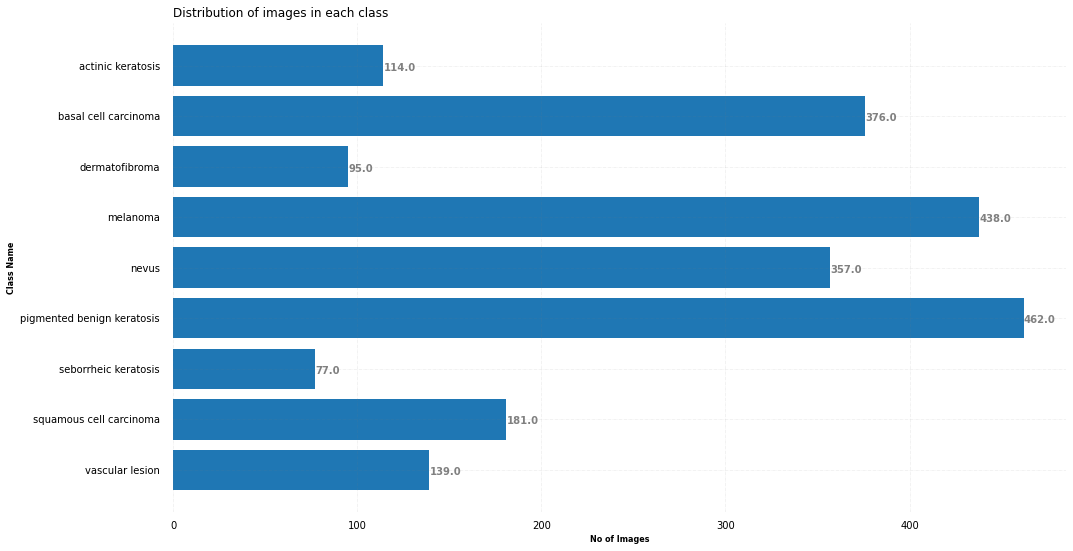

In [27]:
y_axis= dfx['ClassName']
x_axis = dfx['No Of Images']
 
# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
 
# Horizontal Bar Plot
ax.barh(y_axis, x_axis)
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
 
# Add Plot Title
ax.set_title('Distribution of images in each class',
             loc ='left', )
 
plt.xlabel('No of Images', fontweight ='bold', fontsize = 8)
plt.ylabel('Class Name', fontweight ='bold', fontsize = 8)
 
# Show Plot
plt.show()


#### **Todo:** Write your findings here: 
#### The Class Seborrheic Keratosis has the least number of samples.
#### Classes'Pigmented benign keratosis' , 'melanoma' are dominant in terms of proportionate number of Samples
#### Classes 'basal cell carcinoma' and 'nevus' also have quite high proportion of samples


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [28]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [29]:
path_to_training_dataset='/content/gdrive/MyDrive/SkinCancerDataset/Train/'

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancerDataset/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2E1C4FCE10>: 100%|██████████| 500/500 [00:19<00:00, 26.02 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancerDataset/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2E1E0E1E50>: 100%|██████████| 500/500 [00:20<00:00, 24.21 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancerDataset/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2E1E0F9290>: 100%|██████████| 500/500 [00:17<00:00, 28.12 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancerDataset/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7F2E1E8EC850>: 100%|██████████| 500/500 [01:26<00:00,  5.77 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancerDataset/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2E1E0389D0>: 100%|██████████| 500/500 [01:11<00:00,  7.02 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancerDataset/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F2E1E045AD0>: 100%|██████████| 500/500 [00:18<00:00, 27.50 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancerDataset/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F2E1E74FA50>: 100%|██████████| 500/500 [00:40<00:00, 12.37 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancerDataset/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2E1E047B50>: 100%|██████████| 500/500 [00:17<00:00, 28.28 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinCancerDataset/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2E1E9DF110>: 100%|██████████| 500/500 [00:17<00:00, 28.38 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [30]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [31]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/SkinCancerDataset/Train/nevus/output/nevus_original_ISIC_0026194.jpg_cc51beb4-7374-4c91-bb4c-b175561b5115.jpg',
 '/content/gdrive/MyDrive/SkinCancerDataset/Train/nevus/output/nevus_original_ISIC_0000058.jpg_3a4885d7-f718-4a69-b2f7-4625e7a2acf7.jpg',
 '/content/gdrive/MyDrive/SkinCancerDataset/Train/nevus/output/nevus_original_ISIC_0000336.jpg_a1df924e-2c7e-4722-a2c8-098c9ba4d675.jpg',
 '/content/gdrive/MyDrive/SkinCancerDataset/Train/nevus/output/nevus_original_ISIC_0000322.jpg_8c9a1cb7-b57d-46a1-a3d9-bc048e4535e2.jpg',
 '/content/gdrive/MyDrive/SkinCancerDataset/Train/nevus/output/nevus_original_ISIC_0000321.jpg_7caf571a-44ae-4c60-a602-2cf1df2241b6.jpg',
 '/content/gdrive/MyDrive/SkinCancerDataset/Train/nevus/output/nevus_original_ISIC_0000544.jpg_870fe076-d24b-491c-bf61-ab279ca54e26.jpg',
 '/content/gdrive/MyDrive/SkinCancerDataset/Train/nevus/output/nevus_original_ISIC_0000051.jpg_54cc2c5f-9e40-40df-a531-226f480a34a0.jpg',
 '/content/gdrive/MyDrive/SkinCanc

In [32]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [33]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [34]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])


In [35]:
df2['Label'].value_counts()


nevus                         500
vascular lesion               500
actinic keratosis             500
pigmented benign keratosis    500
squamous cell carcinoma       500
seborrheic keratosis          500
melanoma                      500
dermatofibroma                500
basal cell carcinoma          500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [36]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [37]:
data_dir_train="/content/gdrive/MyDrive/SkinCancerDataset/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width), batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [38]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [39]:

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [40]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [41]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 41s 233ms/step - loss: 2.4161 - accuracy: 0.2734 - val_loss: 30.4179 - val_accuracy: 0.1151
Epoch 2/30
169/169 [==============================] - 29s 169ms/step - loss: 1.6088 - accuracy: 0.4008 - val_loss: 34.3158 - val_accuracy: 0.1166
Epoch 3/30
169/169 [==============================] - 30s 173ms/step - loss: 1.4407 - accuracy: 0.4403 - val_loss: 4.6187 - val_accuracy: 0.2279
Epoch 4/30
169/169 [==============================] - 29s 167ms/step - loss: 1.3317 - accuracy: 0.4828 - val_loss: 1.8146 - val_accuracy: 0.4068
Epoch 5/30
169/169 [==============================] - 29s 169ms/step - loss: 1.1792 - accuracy: 0.5384 - val_loss: 1.3489 - val_accuracy: 0.5182
Epoch 6/30
169/169 [==============================] - 29s 164ms/step - loss: 1.0278 - accuracy: 0.5855 - val_loss: 1.0978 - val_accuracy: 0.5887
Epoch 7/30
169/169 [==============================] - 30s 173ms/step - loss: 0.8607 - accuracy: 0.6517 - val_loss: 1.1708 - val_

#### **Todo:**  Visualize the model results

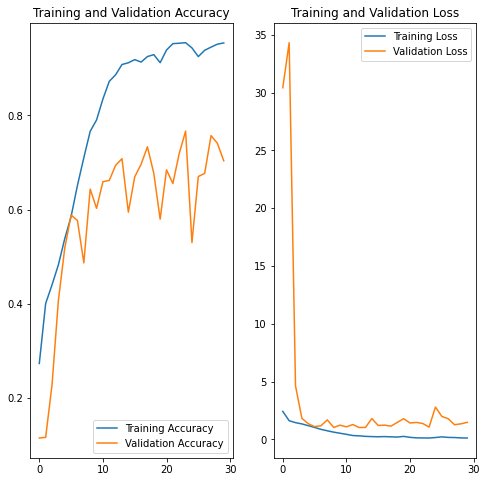

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



### The model still seems to overfit . but the difference between the training and validation accuracy has reduced to a vast extend.
### Hence rebalancing using Augmentor Library helped to reduce the overfitting.